In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
# Imports
import operator as op

# sklearn
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, mean_squared_error, plot_confusion_matrix

# stats models
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# XGBoost
from xgboost import XGBClassifier

In [108]:
# Import the data
train = pd.read_csv('../input/spaceship-titanic/train.csv')
test = pd.read_csv('../input/spaceship-titanic/test.csv')

In [109]:
# Check sizes
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Train shape: (8693, 14)
Test shape: (4277, 13)


In [110]:
# View train
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [111]:
# Describe the training set
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [112]:
# Describe test set
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [113]:
# Unique values
for col in train.columns:
    if (train[col].dtype == 'object'):
        print(f"{col}: {train[col].unique()}")

PassengerId: ['0001_01' '0002_01' '0003_01' ... '9279_01' '9280_01' '9280_02']
HomePlanet: ['Europa' 'Earth' 'Mars' nan]
CryoSleep: [False True nan]
Cabin: ['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']
Destination: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
VIP: [False True nan]
Name: ['Maham Ofracculy' 'Juanna Vines' 'Altark Susent' ... 'Fayey Connon'
 'Celeon Hontichre' 'Propsh Hontichre']


In [114]:
# Test unique values
for col in test.columns:
    if (test[col].dtype == 'object'):
        print(f"{col}: {test[col].unique()}")

PassengerId: ['0013_01' '0018_01' '0019_01' ... '9271_01' '9273_01' '9277_01']
HomePlanet: ['Earth' 'Europa' 'Mars' nan]
CryoSleep: [True False nan]
Cabin: ['G/3/S' 'F/4/S' 'C/0/S' ... 'D/296/P' 'D/297/P' 'G/1498/S']
Destination: ['TRAPPIST-1e' '55 Cancri e' 'PSO J318.5-22' nan]
VIP: [False nan True]
Name: ['Nelly Carsoning' 'Lerome Peckers' 'Sabih Unhearfus' ... 'Jayrin Pore'
 'Kitakan Conale' 'Lilace Leonzaley']


In [115]:
# Null values
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [116]:
# Test null values
test.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [117]:
# Train duplicate check
train.duplicated(keep=False)

0       False
1       False
2       False
3       False
4       False
        ...  
8688    False
8689    False
8690    False
8691    False
8692    False
Length: 8693, dtype: bool

In [118]:
# Test duplicate check
test.duplicated(keep=False)

0       False
1       False
2       False
3       False
4       False
        ...  
4272    False
4273    False
4274    False
4275    False
4276    False
Length: 4277, dtype: bool

In [119]:
# Target variable
target = train.Transported

In [120]:
# Label Encoder
enc = LabelEncoder()

# Fit to the target
y = enc.fit_transform(target)

In [121]:
# Retain PassengerId separately for submitting predictions
passenger_id = test.PassengerId

Previous iterations of work on this competition revealed an overfitted model that stemmed from problems in the construction of the model itself. This notebook will explore more feature engineering techniques to try and improve the model that is created.

# Missing Data

For categorical data, it is best to use the most frequent response to replace missing data. For continuous variables, like Age or RoomService, the choice comes down to mean or median. This choice is best made based on the distribution of data.

## Continuous Variables

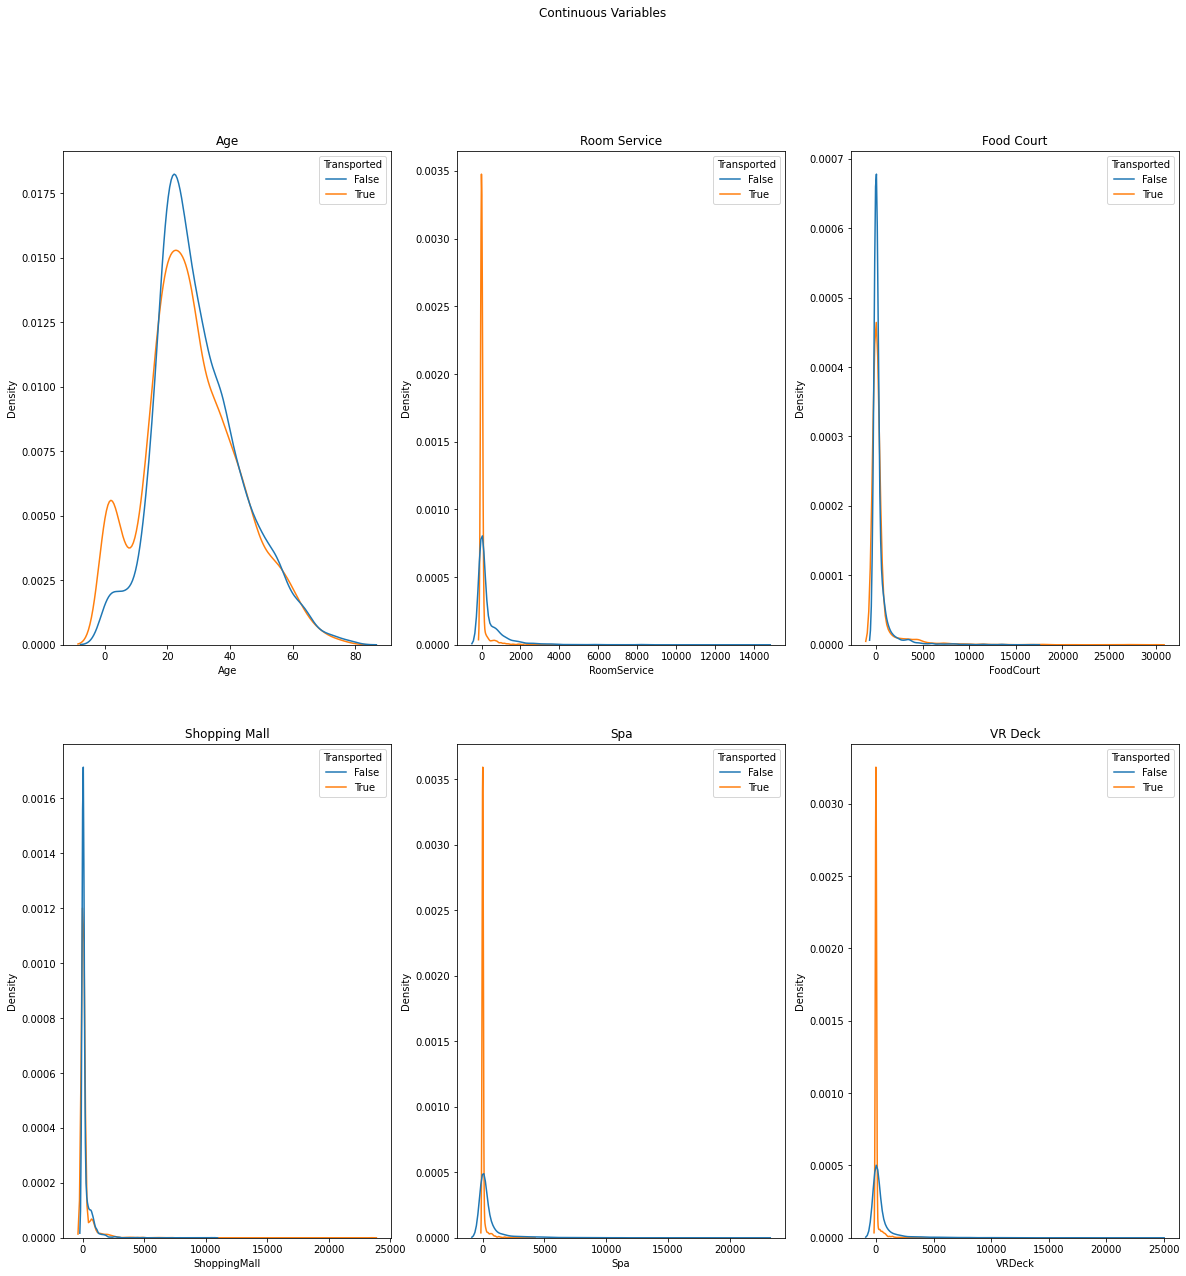

In [122]:
# View continuous variable distributions
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2, 3, figsize=(20,20))

# Title
fig.suptitle('Continuous Variables')
ax0.set_title('Age')
ax1.set_title('Room Service')
ax2.set_title('Food Court')
ax3.set_title('Shopping Mall')
ax4.set_title('Spa')
ax5.set_title('VR Deck')

# Visualizations
ax0 = sns.kdeplot(x = 'Age', data = train, hue = 'Transported', ax = ax0)
ax1 = sns.kdeplot(x = 'RoomService', data = train, hue = 'Transported', ax = ax1)
ax2 = sns.kdeplot(x = 'FoodCourt', data = train, hue = 'Transported', ax = ax2)
ax3 = sns.kdeplot(x = 'ShoppingMall', data = train, hue = 'Transported', ax = ax3)
ax4 = sns.kdeplot(x = 'Spa', data = train, hue = 'Transported', ax = ax4)
ax5 = sns.kdeplot(x = 'VRDeck', data = train, hue = 'Transported', ax = ax5)

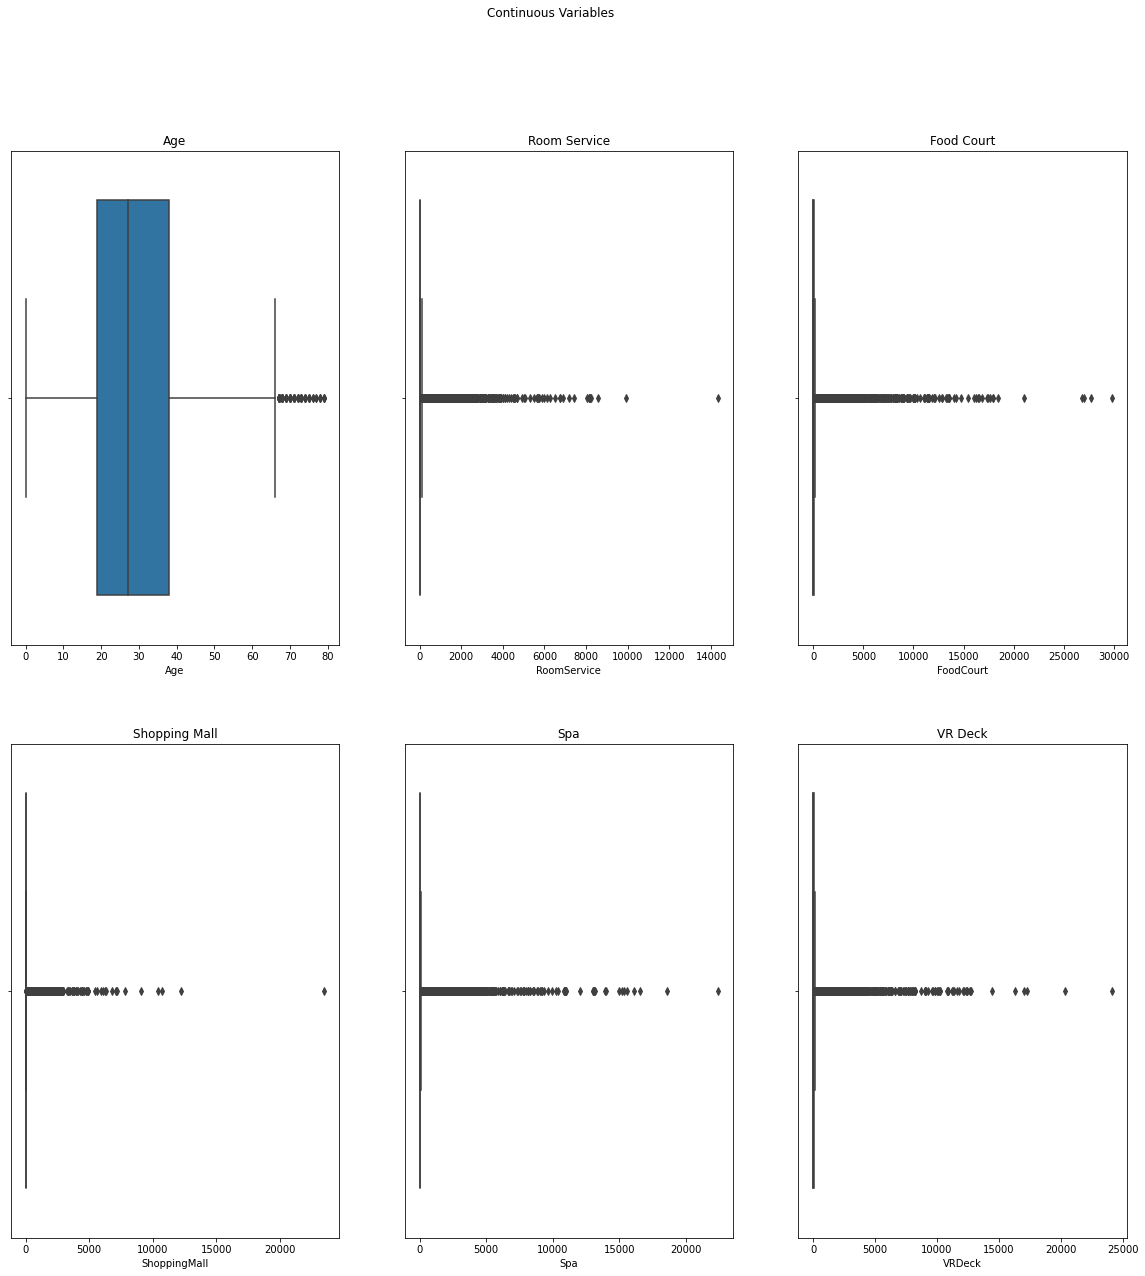

In [123]:
# Boxplots
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2, 3, figsize=(20,20))

# Title
fig.suptitle('Continuous Variables')
ax0.set_title('Age')
ax1.set_title('Room Service')
ax2.set_title('Food Court')
ax3.set_title('Shopping Mall')
ax4.set_title('Spa')
ax5.set_title('VR Deck')

# Visualizations
ax0 = sns.boxplot(x = 'Age', data = train, ax = ax0)
ax1 = sns.boxplot(x = 'RoomService', data = train, ax = ax1)
ax2 = sns.boxplot(x = 'FoodCourt', data = train, ax = ax2)
ax3 = sns.boxplot(x = 'ShoppingMall', data = train, ax = ax3)
ax4 = sns.boxplot(x = 'Spa', data = train, ax = ax4)
ax5 = sns.boxplot(x = 'VRDeck', data = train, ax = ax5)

Age has a close to normal distribution, and given the sample size it's OK to use the mean as a measure of central tendency. The rest, however, show a significant positive skew and as such should use the median value. Furthermore, these variables will each be replaced by two variables:
- Missingness indicator: If the original value is 0, this column will indicate a 1 for true. If non-zero, it will indicate false with a 0.
- Log(x+1) transformation of the base value.

Looking at the boxplots,there are a significant set of outliers for several of the variables, it seems:
- RoomService
- FoodCourt
- ShoppingMall
- Spa
- VRDeck

These, along with any zero values, can be handled with transformations.

## Categorical Variables

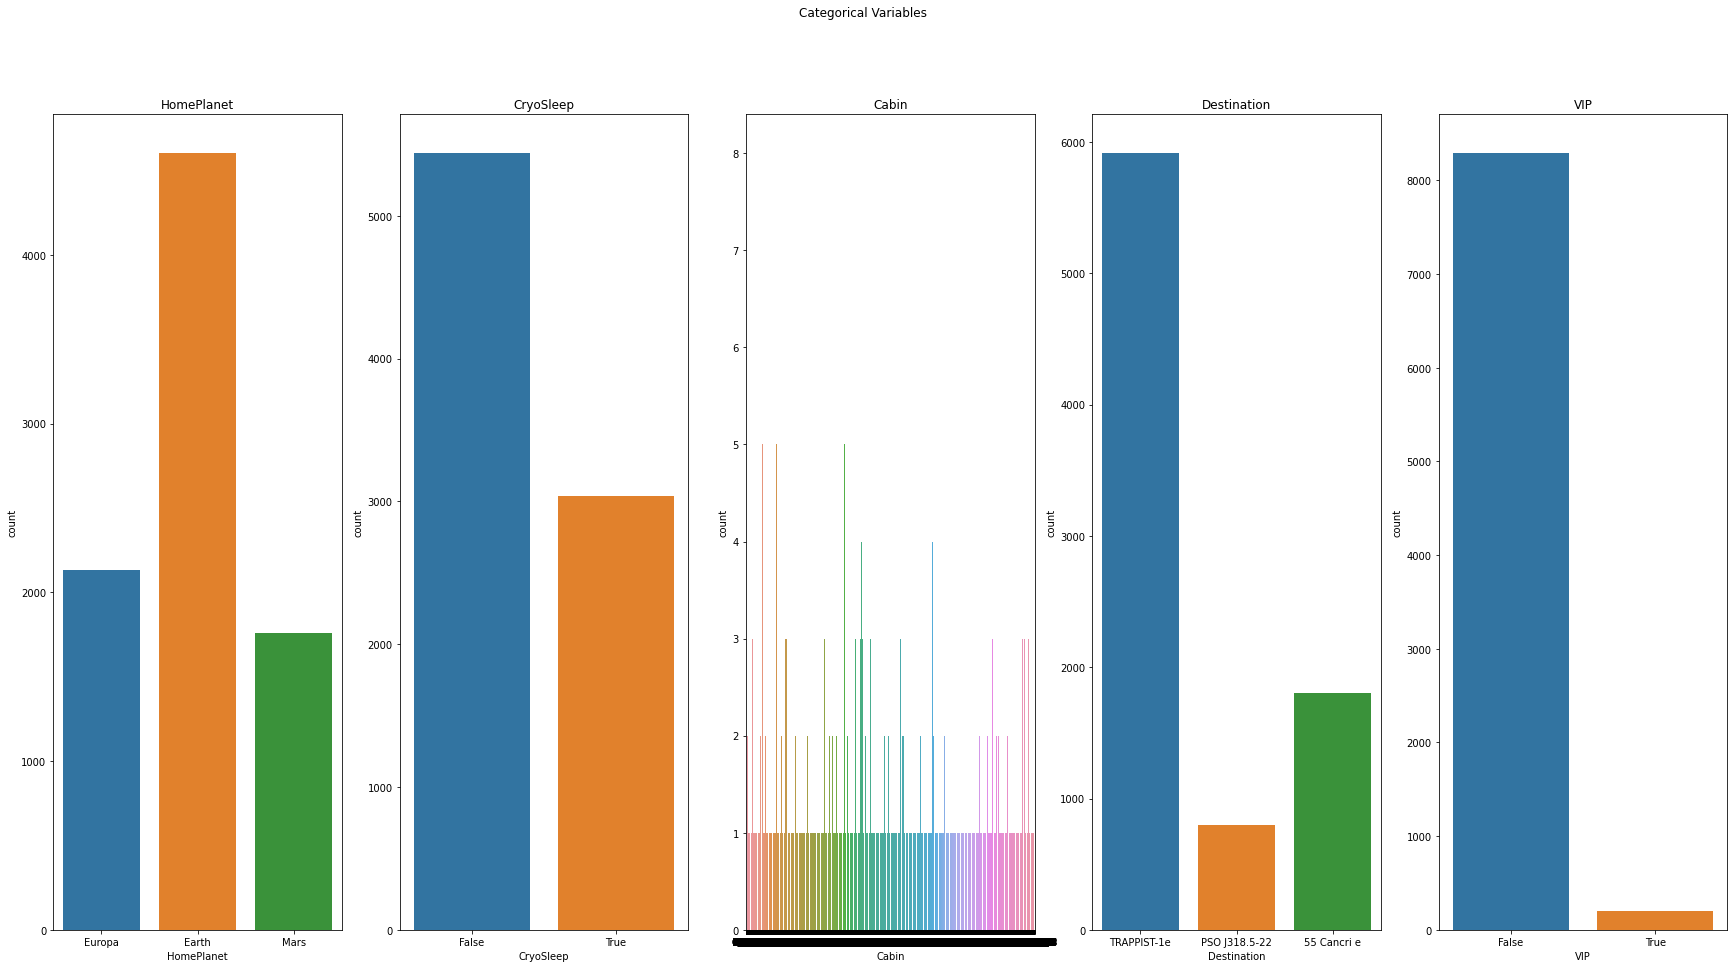

In [128]:
# Countplots
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(30,15))

# Title
fig.suptitle('Categorical Variables')
ax0.set_title('HomePlanet')
ax1.set_title('CryoSleep')
ax2.set_title('Cabin')
ax3.set_title('Destination')
ax4.set_title('VIP')

# Visualizations
ax0 = sns.countplot(x = 'HomePlanet', data = train, ax = ax0)
ax1 = sns.countplot(x = 'CryoSleep', data = train, ax = ax1)
ax2 = sns.countplot(x = 'Cabin', data = train, ax = ax2)
ax3 = sns.countplot(x = 'Destination', data = train, ax = ax3)
ax4 = sns.countplot(x = 'VIP', data = train, ax = ax4)

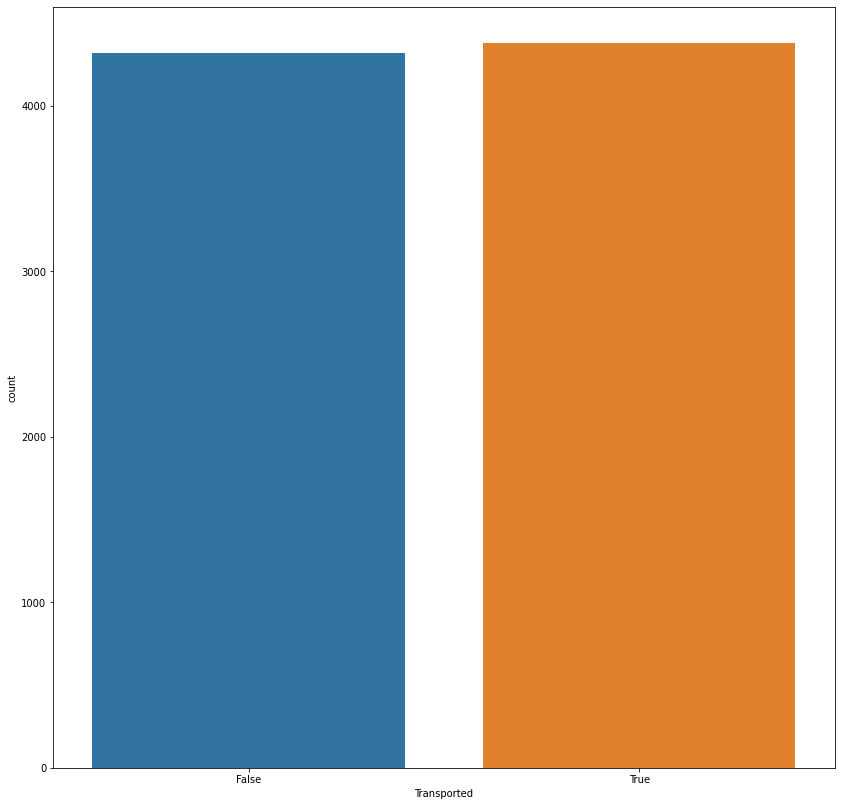

In [131]:
# Dependent variable
plt.figure(figsize=(14,14))

# barchart
sns.countplot(x = 'Transported', data = train)

# Show
plt.show()

In [132]:
# Columns with missing values
train_nan_cols = train.columns[train.isnull().any()]

# Replace missing values in Age with mean
train.Age.fillna(train.Age.mean(), inplace=True)

# Replace missing values in RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck with median
# Replace categorical values with most common values
for col in train_nan_cols:
    if train[col].dtype == 'object':
        train[col].fillna(train[col].mode().iloc[0], inplace=True)
    elif train[col].dtype == 'float64':
        if train[col].name != 'Age':
            train[col].fillna(train[col].median(), inplace=True)
        else:
            # Do nothing
            continue

In [133]:
# Check that there are no null values
train.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

In [134]:
# Columns with missing values
test_nan_cols = test.columns[test.isnull().any()]

# Replace missing values in Age with mean
test.Age.fillna(test.Age.mean(), inplace=True)

# Replace missing values in RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck with median
# Replace categorical values with most common values
for col in test_nan_cols:
    if test[col].dtype == 'object':
        test[col].fillna(test[col].mode().iloc[0], inplace=True)
    elif test[col].dtype == 'float64':
        if test[col].name != 'Age':
            test[col].fillna(test[col].median(), inplace=True)
        else:
            # Do nothing
            continue

In [135]:
# Check that there are no null values
test.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
dtype: int64

In [136]:
# Drop Name from train and test
train.drop(['Name'], axis = 1)
test.drop(['Name'], axis = 1)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.000000,False,0.0,0.0,0.0,0.0,0.0
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.000000,False,0.0,9.0,0.0,2823.0,0.0
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.000000,False,0.0,0.0,0.0,0.0,0.0
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.000000,False,0.0,6652.0,0.0,181.0,585.0
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.000000,False,10.0,0.0,635.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.000000,False,0.0,0.0,0.0,0.0,0.0
4273,9269_01,Earth,False,G/160/P,TRAPPIST-1e,42.000000,False,0.0,847.0,17.0,10.0,144.0
4274,9271_01,Mars,True,D/296/P,55 Cancri e,28.658146,False,0.0,0.0,0.0,0.0,0.0
4275,9273_01,Europa,False,D/297/P,TRAPPIST-1e,28.658146,False,0.0,2680.0,0.0,0.0,523.0


## Zero-Value Detection and Transformations

Columns for zero-value detection and transformations are:
- RoomService
- FoodCourt
- ShoppingMall
- Spa
- VRDeck

In [137]:
# Missingness indicator
# col_name should be in format df.column
def zeroDetector(col_name):
    # list to hold one hot encoding
    zero_detect = []
    # Iterate through column list
    for i in col_name:
        if i == 0.0:
            zero_detect.append(1)
        elif i > 0.0:
            zero_detect.append(0)
        else:
            print("Negative value at {}".format(col_name.loc[i]))
    # Return zero_detect
    return zero_detect

In [138]:
# Log transform all values
# col_name should be in format df.column
def logTx(col_name):
    # Hold transformed column values
    tx_col = np.log(col_name + 1)
    # Return tx_col
    return tx_col

#### Training Set

In [139]:
# RoomService
train_roomservice_zeroes = zeroDetector(train.RoomService)
train_roomservice_tfmd = logTx(train.RoomService)

# FoodCourt
train_foodcourt_zeroes = zeroDetector(train.FoodCourt)
train_foodcourt_tfmd = logTx(train.FoodCourt)

# ShoppingMall
train_shoppingmall_zeroes = zeroDetector(train.ShoppingMall)
train_shoppingmall_tfmd = logTx(train.ShoppingMall)

# Spa
train_spa_zeroes = zeroDetector(train.Spa)
train_spa_tfmd = logTx(train.Spa)

# VRDeck
train_vrdeck_zeroes = zeroDetector(train.VRDeck)
train_vrdeck_tfmd = logTx(train.VRDeck)

#### Testing Set

In [140]:
# RoomService
test_roomservice_zeroes = zeroDetector(test.RoomService)
test_roomservice_tfmd = logTx(test.RoomService)

# FoodCourt
test_foodcourt_zeroes = zeroDetector(test.FoodCourt)
test_foodcourt_tfmd = logTx(test.FoodCourt)

# ShoppingMall
test_shoppingmall_zeroes = zeroDetector(test.ShoppingMall)
test_shoppingmall_tfmd = logTx(test.ShoppingMall)

# Spa
test_spa_zeroes = zeroDetector(test.Spa)
test_spa_tfmd = logTx(test.Spa)

# VRDeck
test_vrdeck_zeroes = zeroDetector(test.VRDeck)
test_vrdeck_tfmd = logTx(test.VRDeck)

## PassengerId

PassengerId has two components separated by an underscore. The first component is a group identifier, and the second component is counter to describe how many travelers are in the identified group. This variable can therefore be split and used to create a new variable that tracks how many traveling companions an individual traveler has.

In [141]:
# Split PassengerId into its component parts and count the number of traveling companions per traveler
# p_id_col is a column in a dataframe. Pass it as df.column
def passengerIdSplitter(p_id_col):
    # Split PassengerID to find traveling companions
    groups = [i.split('_')[0] for i in p_id_col]
    # Hold the companion counts
    companion_count = []
    # Count the companions
    for p in p_id_col:
        # Reset
        count = 0
        # Split to get the group id
        group = p.split('_')[0]
        # Count instances - 1 for companion count
        count = op.countOf(groups, group)-1
        # Add to list
        companion_count.append(count)
    # Return full list of counts
    return companion_count

#### Training Set

In [142]:
# Get companion count for PassengerId in train data set
train_companion_count = passengerIdSplitter(train.PassengerId)

#### Testing Set

In [143]:
# Get companion count for PassengerId in train data set
test_companion_count = passengerIdSplitter(test.PassengerId)

## Cabin

Cabin will be split into 3 levels:
- deck
- level
- side

In [144]:
# Split cabin into deck, level, and side
# cabin_col should be entered in the format df.cabin
def cabinSplitter(cabin_col):
    # Create the lists to house the variables
    deck = []
    level = []
    side = []
    # Create deck, level, and room type
    for c in cabin_col:
        # If there is a null value
        if c is np.nan:
            deck.append(np.nan)
            level.append(np.nan)
            side.append(np.nan)
        # If not null
        else:
            c_split = str(c).split('/', maxsplit=-1)
            deck.append(c_split[0])
            level.append(c_split[1])
            side.append(c_split[2])
    # Return
    return deck, level, side

#### Training Set

In [145]:
# Get deck, level, and side for train dataframe
train_deck, train_level, train_side = cabinSplitter(train.Cabin)

In [146]:
# Add to the training data set
train.insert(4, 'deck', train_deck)
train.insert(5, 'level', train_level)
train.insert(6, 'side', train_side)

# Check
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,deck,level,side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,B,0,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,F,0,S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,A,0,S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,A,0,S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,F,1,S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


#### Testing Set

In [147]:
# Get deck, level, and side for test dataframe
test_deck, test_level, test_side = cabinSplitter(test.Cabin)

In [148]:
# Add to the training data set
test.insert(4, 'deck', test_deck)
test.insert(5, 'level', test_level)
test.insert(6, 'side', test_side)

# Check
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,deck,level,side,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,G,3,S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,F,4,S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,C,0,S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,C,1,S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,F,5,S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


## Level

According to the level column, the highest value is 1894, and the lowest is 0. New categories will be created off of these values as follows:
- 0 to 400
- 401 to 800
- 801 to 1200
- 1201 to 1600
- 1601 to 2000

In [149]:
# Create categories of levels
# level_col should be entered as df.level
def levelCategorizer(level_col):
    # Create a list categorizing each level category
    level_cat = []
    # Iterate through each value in the level column
    for l in level_col:
        if isinstance(l, str):
            # Convert l into into
            l = int(l)
            if l < 401:
                level_cat.append('<=400')
            elif l < 801:
                level_cat.append('401 - 800')
            elif l < 1201:
                level_cat.append('801 - 1200')
            elif l < 1601:
                level_cat.append('1201 - 1600')
            elif l < 2001:
                level_cat.append('1601 - 2000')
            else:
                # Do nothing
                continue
        else:
            level_cat.append(np.nan)
    # Return the level categories
    return level_cat

#### Training Set

In [150]:
# Get the categories
train_level_cat = levelCategorizer(train.level)

#### Testing Set

In [151]:
# Get the categories
test_level_cat = levelCategorizer(test.level)

## Age Conversion

In [152]:
# Age range
print(f"Minimum age: {min(train.Age)}.")
print(f"Maximum age: {max(train.Age)}.")

Minimum age: 0.0.
Maximum age: 79.0.


In [153]:
# Create age categories
# age_col should be provided as df.Age
def ageRanger(age_col):
    # Hold the age ranges
    age_ranges = []
    # Set the values
    for a in age_col:
        if a <= 10.0:
            age_ranges.append("<=10.0")
        elif a < 21.0:
            age_ranges.append("11.0 - 20.0")
        elif a < 31.0:
            age_ranges.append("21.0 - 30.0")
        elif a < 41.0:
            age_ranges.append("31.0 - 40.0")
        elif a < 51.0:
            age_ranges.append("41.0 - 50.0")
        elif a < 61.0:
            age_ranges.append("51.0 - 60.0")
        elif a < 71.0:
            age_ranges.append("61.0 - 70.0")
        elif a < 81.0:
            age_ranges.append("71.0 - 80.0")
        else:
            age_ranges.append(np.nan)
    # Return the age ranges
    return age_ranges

#### Training Set

In [154]:
# Get age ranges for training data
train_age_ranges = ageRanger(train.Age)

#### Testing Set

In [155]:
# Get age ranges for testing data
test_age_ranges = ageRanger(test.Age)

## Drop Variables

__Variables to drop:__
- PassengerId
- Cabin
- level
- Room Service
- Food Court
- Shopping Mall
- Spa
- VRDeck

__Variables to add:__
- companion_count
- level_range
- roomservice_zeroes
- roomservice_tfmd
- foodcourt_zeroes
- foodcourt_tfmd
- shoppingmall_zeroes
- shoppingmall_tfmd
- spa_zeroes
- spa_tfmd
- vrdeck_zeroes
- vrdeck_tfmd

#### Training Set

In [156]:
# Drop variables
train.drop(['PassengerId', 'Cabin', 'level', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Name', 'Transported'], axis=1, inplace=True)

# Check
train.head()

,HomePlanet,CryoSleep,deck,side,Destination,Age,VIP
0,Europa,False,B,P,TRAPPIST-1e,39.0,False
1,Earth,False,F,S,TRAPPIST-1e,24.0,False
2,Europa,False,A,S,TRAPPIST-1e,58.0,True
3,Europa,False,A,S,TRAPPIST-1e,33.0,False
4,Earth,False,F,S,TRAPPIST-1e,16.0,False


In [157]:
# Add variables
train.insert(0, 'companion_count', train_companion_count)
train.insert(4, 'level_range', train_level_cat)
#train.insert(7, 'age_range', train_age_ranges)
train.insert(8, 'roomservice_zeroes', train_roomservice_zeroes)
train.insert(9, 'roomservice_tfmd', train_roomservice_tfmd)
train.insert(10, 'foodcourt_zeroes', train_foodcourt_zeroes)
train.insert(11, 'foodcourt_tfmd', train_foodcourt_tfmd)
train.insert(12, 'shoppingmall_zeroes', train_shoppingmall_zeroes)
train.insert(13, 'shoppingmall_tfmd', train_shoppingmall_tfmd)
train.insert(14, 'spa_zeroes', train_spa_zeroes)
train.insert(15, 'spa_tfmd', train_spa_tfmd)
train.insert(16, 'vrdeck_zeroes', train_vrdeck_zeroes)
train.insert(17, 'vrdeck_tfmd', train_vrdeck_tfmd)

In [158]:
# Check
train.head()

,companion_count,HomePlanet,CryoSleep,deck,level_range,side,Destination,Age,roomservice_zeroes,roomservice_tfmd,foodcourt_zeroes,foodcourt_tfmd,shoppingmall_zeroes,shoppingmall_tfmd,spa_zeroes,spa_tfmd,vrdeck_zeroes,vrdeck_tfmd,VIP
0,0,Europa,False,B,<=400,P,TRAPPIST-1e,39.0,1,0.000000,1,0.000000,1,0.000000,1,0.000000,1,0.000000,False
1,0,Earth,False,F,<=400,S,TRAPPIST-1e,24.0,0,4.700480,0,2.302585,0,3.258097,0,6.309918,0,3.806662,False
2,1,Europa,False,A,<=400,S,TRAPPIST-1e,58.0,0,3.784190,0,8.182280,1,0.000000,0,8.812248,0,3.912023,True
3,1,Europa,False,A,<=400,S,TRAPPIST-1e,33.0,1,0.000000,0,7.157735,0,5.918894,0,8.110728,0,5.267858,False
4,0,Earth,False,F,<=400,S,TRAPPIST-1e,16.0,0,5.717028,0,4.262680,0,5.023881,0,6.338594,0,1.098612,False


#### Testing Set

In [159]:
# Drop variables
test.drop(['PassengerId', 'Cabin', 'level', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck','Name'], axis=1, inplace=True)

# Check
test.head()

,HomePlanet,CryoSleep,deck,side,Destination,Age,VIP
0,Earth,True,G,S,TRAPPIST-1e,27.0,False
1,Earth,False,F,S,TRAPPIST-1e,19.0,False
2,Europa,True,C,S,55 Cancri e,31.0,False
3,Europa,False,C,S,TRAPPIST-1e,38.0,False
4,Earth,False,F,S,TRAPPIST-1e,20.0,False


In [160]:
# Add variables
test.insert(0, 'companion_count', test_companion_count)
test.insert(4, 'level_range', test_level_cat)
#test.insert(7, 'age_range', test_age_ranges)
test.insert(8, 'roomservice_zeroes', test_roomservice_zeroes)
test.insert(9, 'roomservice_tfmd', test_roomservice_tfmd)
test.insert(10, 'foodcourt_zeroes', test_foodcourt_zeroes)
test.insert(11, 'foodcourt_tfmd', test_foodcourt_tfmd)
test.insert(12, 'shoppingmall_zeroes', test_shoppingmall_zeroes)
test.insert(13, 'shoppingmall_tfmd', test_shoppingmall_tfmd)
test.insert(14, 'spa_zeroes', test_spa_zeroes)
test.insert(15, 'spa_tfmd', test_spa_tfmd)
test.insert(16, 'vrdeck_zeroes', test_vrdeck_zeroes)
test.insert(17, 'vrdeck_tfmd', test_vrdeck_tfmd)

In [161]:
# Check
test.head()

,companion_count,HomePlanet,CryoSleep,deck,level_range,side,Destination,Age,roomservice_zeroes,roomservice_tfmd,foodcourt_zeroes,foodcourt_tfmd,shoppingmall_zeroes,shoppingmall_tfmd,spa_zeroes,spa_tfmd,vrdeck_zeroes,vrdeck_tfmd,VIP
0,0,Earth,True,G,<=400,S,TRAPPIST-1e,27.0,1,0.000000,1,0.000000,1,0.000000,1,0.000000,1,0.00000,False
1,0,Earth,False,F,<=400,S,TRAPPIST-1e,19.0,1,0.000000,0,2.302585,1,0.000000,0,7.945910,1,0.00000,False
2,0,Europa,True,C,<=400,S,55 Cancri e,31.0,1,0.000000,1,0.000000,1,0.000000,1,0.000000,1,0.00000,False
3,0,Europa,False,C,<=400,S,TRAPPIST-1e,38.0,1,0.000000,0,8.802823,1,0.000000,0,5.204007,0,6.37332,False
4,0,Earth,False,F,<=400,S,TRAPPIST-1e,20.0,0,2.397895,1,0.000000,0,6.455199,1,0.000000,1,0.00000,False


## Ordinal Encoding

Ordinal encoder to be used on the following variables:
- HomePlanet
- CryoSleep
- deck
- level_range
- side
- Destination
- VIP

In [162]:
# Initialize OrdinalEncoder instance
ord = OrdinalEncoder(dtype = 'int64')

#### Training Set

In [163]:
# Encoding variables
train.HomePlanet = ord.fit_transform(train.HomePlanet.to_numpy().reshape(-1,1))
train.CryoSleep = ord.fit_transform(train.CryoSleep.to_numpy().reshape(-1,1))
train.deck = ord.fit_transform(train.deck.to_numpy().reshape(-1,1))
train.level_range = ord.fit_transform(train.level_range.to_numpy().reshape(-1,1))
train.side = ord.fit_transform(train.side.to_numpy().reshape(-1,1))
train.Destination = ord.fit_transform(train.Destination.to_numpy().reshape(-1,1))
#train.age_range = ord.fit_transform(train.age_range.to_numpy().reshape(-1,1))
train.VIP = ord.fit_transform(train.VIP.to_numpy().reshape(-1,1))

# Check
train.head()

,companion_count,HomePlanet,CryoSleep,deck,level_range,side,Destination,Age,roomservice_zeroes,roomservice_tfmd,foodcourt_zeroes,foodcourt_tfmd,shoppingmall_zeroes,shoppingmall_tfmd,spa_zeroes,spa_tfmd,vrdeck_zeroes,vrdeck_tfmd,VIP
0,0,1,0,1,4,0,2,39.0,1,0.000000,1,0.000000,1,0.000000,1,0.000000,1,0.000000,0
1,0,0,0,5,4,1,2,24.0,0,4.700480,0,2.302585,0,3.258097,0,6.309918,0,3.806662,0
2,1,1,0,0,4,1,2,58.0,0,3.784190,0,8.182280,1,0.000000,0,8.812248,0,3.912023,1
3,1,1,0,0,4,1,2,33.0,1,0.000000,0,7.157735,0,5.918894,0,8.110728,0,5.267858,0
4,0,0,0,5,4,1,2,16.0,0,5.717028,0,4.262680,0,5.023881,0,6.338594,0,1.098612,0


#### Testing Set

In [164]:
# Encoding variables
test.HomePlanet = ord.fit_transform(test.HomePlanet.to_numpy().reshape(-1,1))
test.CryoSleep = ord.fit_transform(test.CryoSleep.to_numpy().reshape(-1,1))
test.deck = ord.fit_transform(test.deck.to_numpy().reshape(-1,1))
test.level_range = ord.fit_transform(test.level_range.to_numpy().reshape(-1,1))
test.side = ord.fit_transform(test.side.to_numpy().reshape(-1,1))
test.Destination = ord.fit_transform(test.Destination.to_numpy().reshape(-1,1))
#test.age_range = ord.fit_transform(test.age_range.to_numpy().reshape(-1,1))
test.VIP = ord.fit_transform(test.VIP.to_numpy().reshape(-1,1))

# Check
test.head()

,companion_count,HomePlanet,CryoSleep,deck,level_range,side,Destination,Age,roomservice_zeroes,roomservice_tfmd,foodcourt_zeroes,foodcourt_tfmd,shoppingmall_zeroes,shoppingmall_tfmd,spa_zeroes,spa_tfmd,vrdeck_zeroes,vrdeck_tfmd,VIP
0,0,0,1,6,4,1,2,27.0,1,0.000000,1,0.000000,1,0.000000,1,0.000000,1,0.00000,0
1,0,0,0,5,4,1,2,19.0,1,0.000000,0,2.302585,1,0.000000,0,7.945910,1,0.00000,0
2,0,1,1,2,4,1,0,31.0,1,0.000000,1,0.000000,1,0.000000,1,0.000000,1,0.00000,0
3,0,1,0,2,4,1,2,38.0,1,0.000000,0,8.802823,1,0.000000,0,5.204007,0,6.37332,0
4,0,0,0,5,4,1,2,20.0,0,2.397895,1,0.000000,0,6.455199,1,0.000000,1,0.00000,0


# Exploratory Data Analysis

## Collinearity Check

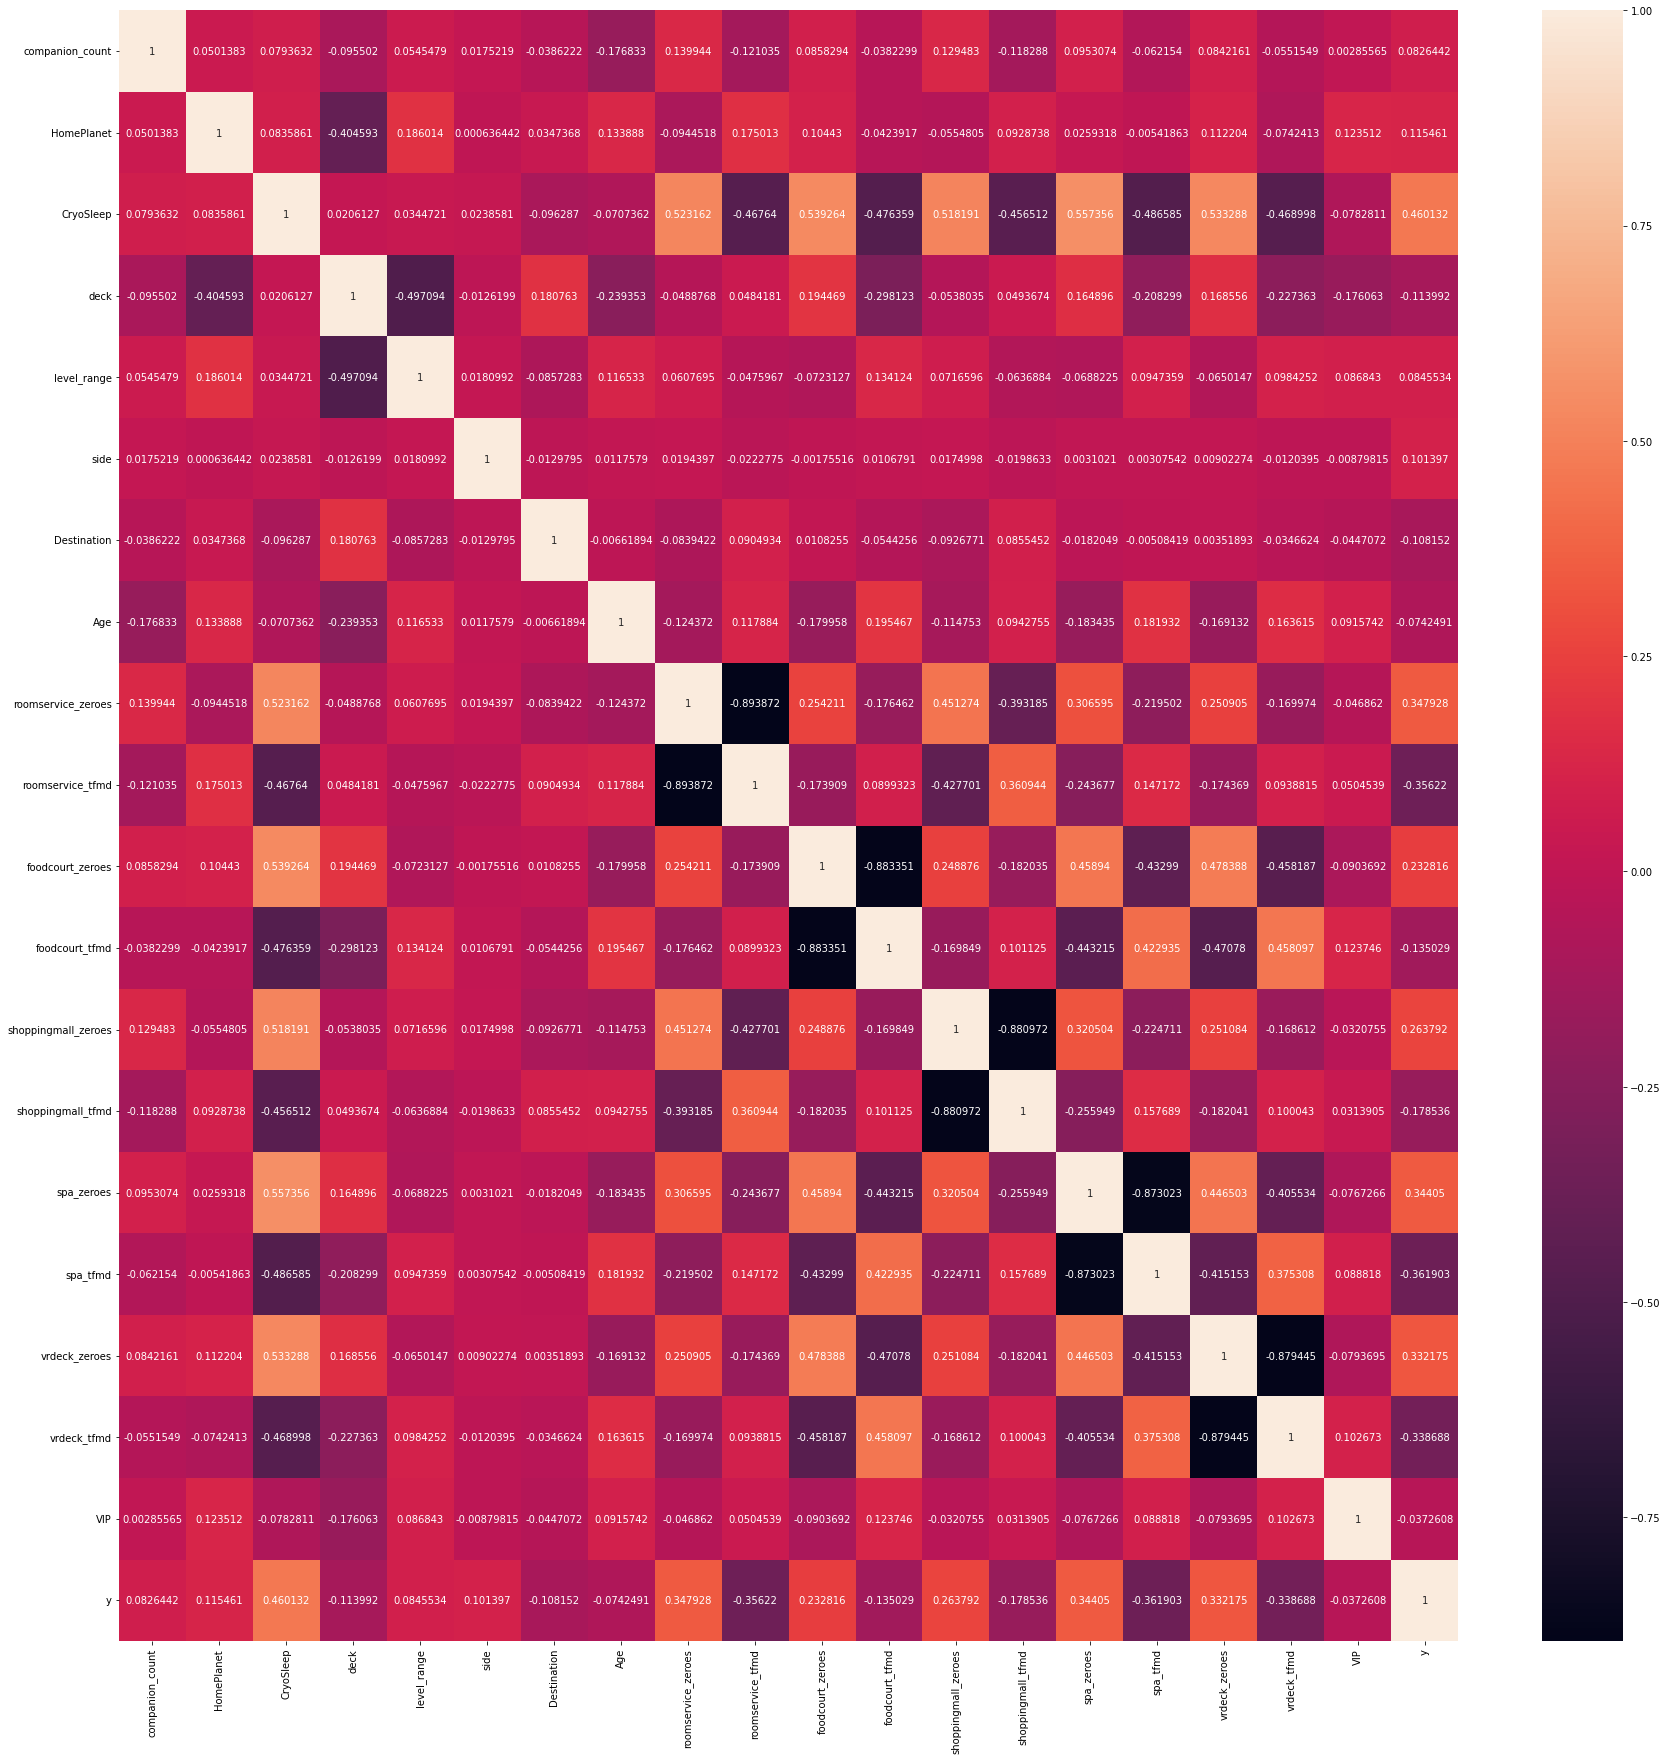

In [165]:
# Include the predicted variable
train['y']=y

# Heatmap
plt.figure(figsize=(30,30))

sns.heatmap(train.corr(), annot = True, fmt = 'g')

plt.show()

Some of these variables have low R values with regards to the target variable, y. 
- companion_count
- level_range
- Age

Other variables, particularly the missingness indicators and transformed cost variables, have high multicollinearity. VIF values should be checked just in case.

In [166]:
# Calculate the VIF
# X is a dataframe, target is the dependent variable column's name
def calcVIF(X, target=None):
    # Drop the target variable first
    if target != None:
        X.drop([target], axis=1, inplace=True)
        # Calculating VIF
        vif = pd.DataFrame()
        vif["variables"] = X.columns
        vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    # Proceed if there is no target variable
    else:
        # Calculating VIF
        vif = pd.DataFrame()
        vif["variables"] = X.columns
        vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    # Return the vif dataframe
    return(vif) 

In [167]:
# First VIF check
calcVIF(train, target='y')

,variables,VIF
0,companion_count,1.532246
1,HomePlanet,2.433785
2,CryoSleep,4.173228
3,deck,10.686347
4,level_range,6.234177
5,side,2.057701
6,Destination,4.575152
7,Age,5.661784
8,roomservice_zeroes,14.091696
9,roomservice_tfmd,6.322998


Several of the predictor variables have VIF values over 10.0. They are:
- roomservice_zeroes, 14.09
- shoppingmall_zeroes, 13.11
- foodcourt_zeroes, 12.68
- vrdeck_zeroes, 12.61
- spa_zeroes, 11.58
- deck, 10.69

Regardless, the first pass of this model will run with all of these variables included.

In [60]:
# Drop unneeded columns
#train.drop(['companion_count', 'level_range', 'Age'], axis=1, inplace=True)


# Check
#train.head()

,HomePlanet,CryoSleep,deck,side,Destination,roomservice_zeroes,roomservice_tfmd,foodcourt_zeroes,foodcourt_tfmd,shoppingmall_zeroes,shoppingmall_tfmd,spa_zeroes,spa_tfmd,vrdeck_zeroes,vrdeck_tfmd,VIP
0,1,0,1,0,2,1,0.000000,1,0.000000,1,0.000000,1,0.000000,1,0.000000,0
1,0,0,5,1,2,0,4.700480,0,2.302585,0,3.258097,0,6.309918,0,3.806662,0
2,1,0,0,1,2,0,3.784190,0,8.182280,1,0.000000,0,8.812248,0,3.912023,1
3,1,0,0,1,2,1,0.000000,0,7.157735,0,5.918894,0,8.110728,0,5.267858,0
4,0,0,5,1,2,0,5.717028,0,4.262680,0,5.023881,0,6.338594,0,1.098612,0


In [61]:
# Drop unneeded columns from test
#test.drop(['companion_count', 'level_range', 'Age'], axis=1, inplace=True)

# Check
#test.head()

,HomePlanet,CryoSleep,deck,side,Destination,roomservice_zeroes,roomservice_tfmd,foodcourt_zeroes,foodcourt_tfmd,shoppingmall_zeroes,shoppingmall_tfmd,spa_zeroes,spa_tfmd,vrdeck_zeroes,vrdeck_tfmd,VIP
0,0,1,6,1,2,1,0.000000,1,0.000000,1,0.000000,1,0.000000,1,0.00000,0
1,0,0,5,1,2,1,0.000000,0,2.302585,1,0.000000,0,7.945910,1,0.00000,0
2,1,1,2,1,0,1,0.000000,1,0.000000,1,0.000000,1,0.000000,1,0.00000,0
3,1,0,2,1,2,1,0.000000,0,8.802823,1,0.000000,0,5.204007,0,6.37332,0
4,0,0,5,1,2,0,2.397895,1,0.000000,0,6.455199,1,0.000000,1,0.00000,0


## Create Training and Validation Sets

In [168]:
# Set split
x_train, x_validation, y_train, y_validation = train_test_split(train, y, test_size=0.1, random_state=42)

In [169]:
# Check shape
print(f"x_train shape: {x_train.shape}.")
print(f"x_validation shape: {x_validation.shape}.")

x_train shape: (7823, 19).
x_validation shape: (870, 19).


In [170]:
# Evaluation sets for each iteration
eval_sets = [(x_train, y_train), (x_validation, y_validation)]

# XGBoost Classifier + GridSearchCV

In [176]:
# Initialize XGBClassifier
xgbc = XGBClassifier(objective= 'binary:logistic',
                     nthread=6,
                     seed=42,
                     eval_metric = 'logloss')

In [177]:
# Parameter dict for XGBC GridSearchCV object
params = {'max_depth': [5, 6, 8, 10, 20],
          'n_estimators': [100, 200, 500, 1000],
          'eta': [0.05, 0.1, 0.03, 0.01]}

In [178]:
# Initialize the GridSearchCV object
gc1 = GridSearchCV(xgbc, param_grid=params, cv=10, n_jobs=-1)

In [179]:
# Fit the grid search object
gc1.fit(x_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     m

In [180]:
# To a dataframe
gc1_results_pd = pd.DataFrame(gc1.cv_results_)

# View
gc1_results_pd

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,2.425389,0.110043,0.011164,0.001492,0.05,5,100,"{'eta': 0.05, 'max_depth': 5, 'n_estimators': ...",0.800766,0.809706,...,0.817136,0.813299,0.795396,0.806905,0.799233,0.791560,0.804348,0.804933,0.007760,43
1,4.582162,0.108008,0.013131,0.005164,0.05,5,200,"{'eta': 0.05, 'max_depth': 5, 'n_estimators': ...",0.800766,0.794381,...,0.817136,0.820972,0.796675,0.813299,0.805627,0.796675,0.806905,0.807619,0.010138,28
2,11.164841,0.169515,0.016646,0.001610,0.05,5,500,"{'eta': 0.05, 'max_depth': 5, 'n_estimators': ...",0.807152,0.802043,...,0.810742,0.814578,0.808184,0.806905,0.822251,0.787724,0.808184,0.808258,0.008650,21
3,21.978825,0.296129,0.021394,0.002825,0.05,5,1000,"{'eta': 0.05, 'max_depth': 5, 'n_estimators': ...",0.800766,0.802043,...,0.815857,0.810742,0.796675,0.800512,0.828645,0.787724,0.804348,0.806213,0.010984,36
4,2.910609,0.086386,0.011959,0.002476,0.05,6,100,"{'eta': 0.05, 'max_depth': 6, 'n_estimators': ...",0.799489,0.802043,...,0.827366,0.815857,0.799233,0.810742,0.809463,0.794118,0.812020,0.809025,0.009858,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,44.716085,0.391960,0.047567,0.016570,0.01,10,1000,"{'eta': 0.01, 'max_depth': 10, 'n_estimators':...",0.795658,0.805875,...,0.824808,0.810742,0.800512,0.814578,0.820972,0.790281,0.815857,0.809921,0.010934,10
76,9.504241,0.280361,0.019910,0.005138,0.01,20,100,"{'eta': 0.01, 'max_depth': 20, 'n_estimators':...",0.798212,0.781609,...,0.810742,0.781330,0.781330,0.795396,0.801790,0.763427,0.797954,0.790106,0.012870,78
77,18.960397,0.387920,0.035952,0.009608,0.01,20,200,"{'eta': 0.01, 'max_depth': 20, 'n_estimators':...",0.790549,0.785441,...,0.817136,0.791560,0.782609,0.803069,0.815857,0.777494,0.789003,0.794710,0.012683,74
78,46.112298,0.380911,0.064034,0.028185,0.01,20,500,"{'eta': 0.01, 'max_depth': 20, 'n_estimators':...",0.799489,0.790549,...,0.828645,0.801790,0.792839,0.803069,0.818414,0.781330,0.794118,0.801995,0.013231,57


# XGBClassifier Based on Best Parameters

In [181]:
# View the best parameters
gc1.best_params_

{'eta': 0.05, 'max_depth': 8, 'n_estimators': 200}

The above parameters produced a training accuracy of 83.6%, and a validation accuracy of 78.9%. There is room to do better.

In [221]:
# Initialize a new XGBClassifier instance
xgbc1 = XGBClassifier(objective= 'binary:logistic',
                      max_depth=8,
                      n_estimators=200,
                      eta=0.05,
                      #colsample_bytree=0.8,
                      #subsample=0.8,
                      #gamma=1.5,
                      nthread=4,
                      seed=42,
                      eval_metric = ['error','logloss']) 

In [222]:
# Fit
xgbc1.fit(x_train, y_train, eval_set = eval_sets)

[0]	validation_0-error:0.18497	validation_0-logloss:0.66931	validation_1-error:0.24138	validation_1-logloss:0.67247
[1]	validation_0-error:0.18369	validation_0-logloss:0.64788	validation_1-error:0.24253	validation_1-logloss:0.65399
[2]	validation_0-error:0.18164	validation_0-logloss:0.62808	validation_1-error:0.24023	validation_1-logloss:0.63681
[3]	validation_0-error:0.17755	validation_0-logloss:0.61011	validation_1-error:0.23448	validation_1-logloss:0.62159
[4]	validation_0-error:0.17704	validation_0-logloss:0.59352	validation_1-error:0.23563	validation_1-logloss:0.60745
[5]	validation_0-error:0.17602	validation_0-logloss:0.57807	validation_1-error:0.23333	validation_1-logloss:0.59482
[6]	validation_0-error:0.17423	validation_0-logloss:0.56406	validation_1-error:0.23218	validation_1-logloss:0.58272
[7]	validation_0-error:0.17346	validation_0-logloss:0.55122	validation_1-error:0.23103	validation_1-logloss:0.57183
[8]	validation_0-error:0.17410	validation_0-logloss:0.53901	validation_1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.05,
              eval_metric=['error', 'logloss'], gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.0500000007,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=8,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=4, nthread=4,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [223]:
# Accuracy score
xgbc1_val_acc_score = accuracy_score(y_validation, xgbc1.predict(x_validation))
xgbc1_train_acc_score = accuracy_score(y_train, xgbc1.predict(x_train))

# View
print(f"Validation set accuracy score: {xgbc1_val_acc_score}.")
print(f"Training set accuracy score: {xgbc1_train_acc_score}.")

Validation set accuracy score: 0.8022988505747126.
Training set accuracy score: 0.8945417359069411.


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


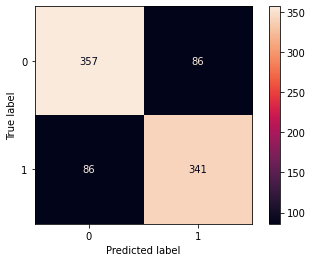

In [224]:
# View confusion matrix
plot_confusion_matrix(xgbc1, x_validation, y_validation, cmap='rocket')

In [225]:
# Validation classification report
print(classification_report(y_validation, xgbc1.predict(x_validation)))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       443
           1       0.80      0.80      0.80       427

    accuracy                           0.80       870
   macro avg       0.80      0.80      0.80       870
weighted avg       0.80      0.80      0.80       870



In [226]:
# Training classification report
print(classification_report(y_train, xgbc1.predict(x_train)))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      3872
           1       0.90      0.89      0.89      3951

    accuracy                           0.89      7823
   macro avg       0.89      0.89      0.89      7823
weighted avg       0.89      0.89      0.89      7823



In [227]:
# Performance metrics
xgbc1_perf_results = xgbc1.evals_result()

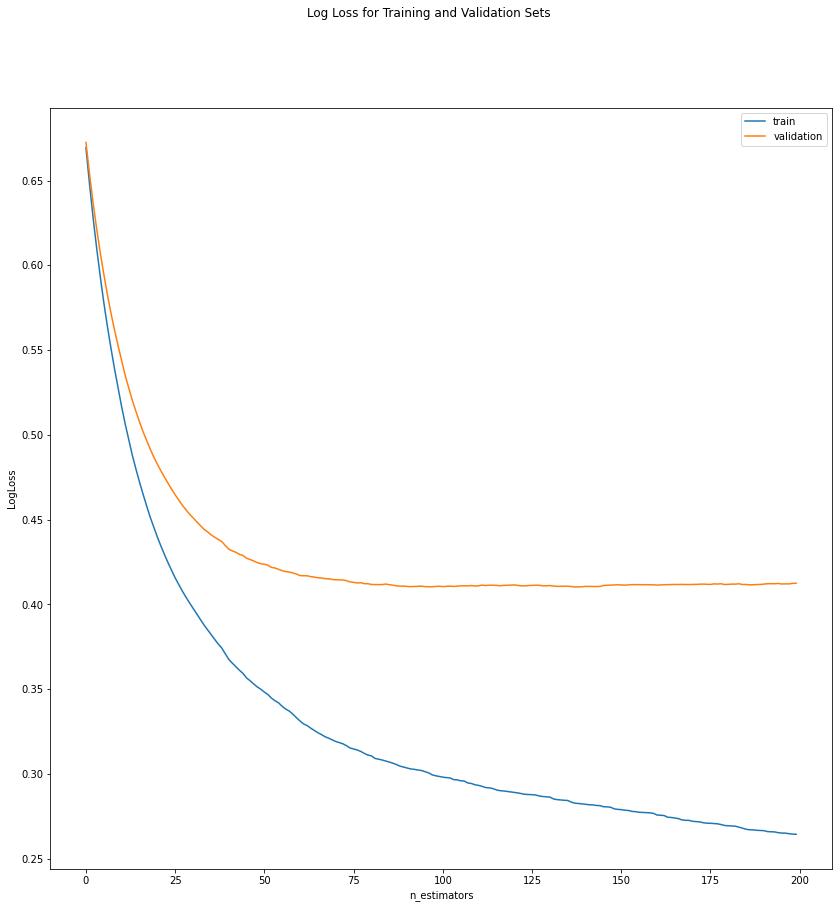

In [228]:
# Plot learning curves
plt.figure(figsize=(14,14))
plt.plot(xgbc1_perf_results['validation_0']['logloss'], label='train')
plt.plot(xgbc1_perf_results['validation_1']['logloss'], label='validation')

# Show where performance flattens out
#plt.axvline(x = 350, color='black')

# Labels
plt.suptitle('Log Loss for Training and Validation Sets')
plt.xlabel('n_estimators')
plt.ylabel('LogLoss')
# show the legend
plt.legend()
# show the plot
plt.show()

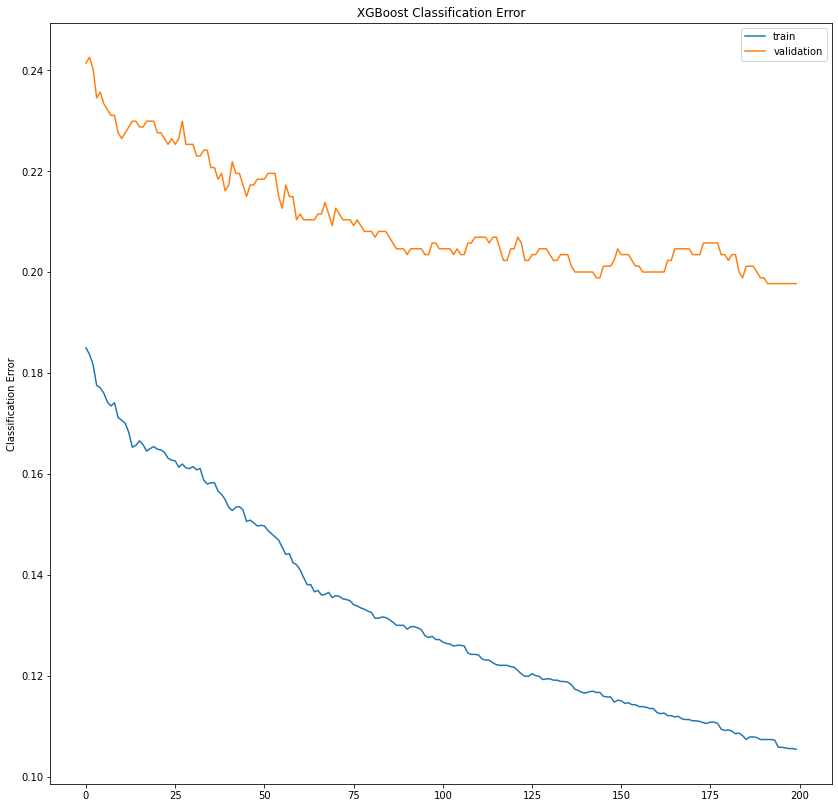

In [229]:
# plot classification error
plt.figure(figsize=(14,14))
plt.plot(xgbc1_perf_results['validation_0']['error'], label='train')
plt.plot(xgbc1_perf_results['validation_1']['error'], label='validation')
plt.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [235]:
# Predictions
xgbc1_preds = xgbc1.predict(test)

In [240]:
# Create a new dataframe
data={'PassengerId':passenger_id, 'Transported':xgbc1_preds}

xgbc1_preds_df=pd.DataFrame(data=data)

# Check
xgbc1_preds_df.head()

,PassengerId,Transported
0,0013_01,0
1,0018_01,0
2,0019_01,1
3,0021_01,1
4,0023_01,1


In [241]:
# Replacements
xgbc1_preds_df.replace(to_replace=0, value='False', inplace=True)
xgbc1_preds_df.replace(to_replace=1, value='True', inplace=True)

# Check
xgbc1_preds_df.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [242]:
# Create the CSV for submission
xgbc1_preds_df.to_csv('xgbc1_submission.csv', index=False)

# Random Forest + GridSearchCV

In [243]:
# Imports
from sklearn.ensemble import RandomForestClassifier

In [244]:
# Initialize a RandomForestClassifier object
rfc = RandomForestClassifier(random_state=42)

In [247]:
# Params list
rfc_params = {'n_estimators': [200, 300, 500, 1000],
              'max_features': ['auto', 'log2'],
              'max_depth' : [6, 8, 10],
              #'min_impurity_decrease': [0, 0.1],
              #'min_samples_leaf': [3, 4, 5],
              #'min_samples_split': [8, 10, 12],
              'criterion' :['gini', 'entropy']}

In [248]:
# New grid search object
gs_rfc = GridSearchCV(rfc, param_grid=rfc_params, cv=10, n_jobs=-1, return_train_score=True)

In [249]:
# Fit the grid search object
gs_rfc.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [6, 8, 10],
                         'max_features': ['auto', 'log2'],
                         'n_estimators': [200, 300, 500, 1000]},
             return_train_score=True)

In [250]:
# Estimator list
# To a dataframe
gs_rfc_results_pd = pd.DataFrame(gs_rfc.cv_results_)

# View
gs_rfc_results_pd

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,1.483276,0.087461,0.067807,0.001663,gini,6,auto,200,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.781609,...,0.803409,0.802585,0.802301,0.803863,0.803153,0.799886,0.802585,0.799318,0.801952,0.001433
1,2.213602,0.099361,0.096320,0.004542,gini,6,auto,300,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.780332,...,0.802699,0.800881,0.802869,0.802869,0.801875,0.799744,0.802727,0.799744,0.801611,0.001188
2,3.729497,0.132515,0.164914,0.018360,gini,6,auto,500,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.777778,...,0.802131,0.801023,0.802869,0.802585,0.801875,0.800454,0.802869,0.799886,0.801667,0.001067
3,7.377535,0.170843,0.304694,0.019480,gini,6,auto,1000,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.780332,...,0.802841,0.801307,0.801875,0.801733,0.802869,0.800028,0.803153,0.800028,0.801795,0.001267
4,1.533978,0.171738,0.065312,0.003006,gini,6,log2,200,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.781609,...,0.803409,0.802585,0.802301,0.803863,0.803153,0.799886,0.802585,0.799318,0.801952,0.001433
5,2.182743,0.013081,0.096651,0.003967,gini,6,log2,300,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.780332,...,0.802699,0.800881,0.802869,0.802869,0.801875,0.799744,0.802727,0.799744,0.801611,0.001188
6,3.627930,0.033277,0.161033,0.013607,gini,6,log2,500,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.777778,...,0.802131,0.801023,0.802869,0.802585,0.801875,0.800454,0.802869,0.799886,0.801667,0.001067
7,7.389712,0.213112,0.303598,0.009066,gini,6,log2,1000,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.780332,...,0.802841,0.801307,0.801875,0.801733,0.802869,0.800028,0.803153,0.800028,0.801795,0.001267
8,1.664894,0.026158,0.070505,0.001807,gini,8,auto,200,"{'criterion': 'gini', 'max_depth': 8, 'max_fea...",0.784163,...,0.829688,0.832694,0.829002,0.830422,0.827865,0.829570,0.830848,0.827155,0.829932,0.001556
9,2.501117,0.028595,0.100294,0.003351,gini,8,auto,300,"{'criterion': 'gini', 'max_depth': 8, 'max_fea...",0.780332,...,0.829830,0.833262,0.828718,0.830564,0.827865,0.828860,0.831132,0.827723,0.830074,0.001771


In [251]:
# Best parameters
gs_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 1000}

## Random Forest Classifier from Best Parameters

In [252]:
# New RandomForestClassifier object
rfc1 = RandomForestClassifier(max_depth=10,
                              max_features='auto',
                              n_estimators=1000, 
                              #min_samples_leaf=3,
                              #min_samples_split=8,
                              criterion='gini',
                              random_state=42)

In [253]:
# Fit
rfc1.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=1000, random_state=42)

### Training Performance

In [254]:
# Accuracy score
print(f"Training accuracy: {accuracy_score(y_train, rfc1.predict(x_train))}.")

Training accuracy: 0.8657803911542886.


In [255]:
# Classification report
print(classification_report(y_train, rfc1.predict(x_train)))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      3872
           1       0.85      0.89      0.87      3951

    accuracy                           0.87      7823
   macro avg       0.87      0.87      0.87      7823
weighted avg       0.87      0.87      0.87      7823



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


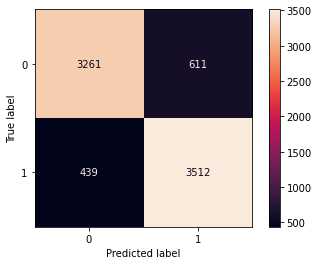

In [256]:
# Confusion Matrix- training set
plot_confusion_matrix(rfc1, x_train, y_train, cmap='rocket')

### Validation Performance

In [257]:
# Accuracy score
print(f"Validation accuracy: {accuracy_score(y_validation, rfc1.predict(x_validation))}.")

Validation accuracy: 0.7816091954022989.


In [258]:
# Validation
print(classification_report(y_validation, rfc1.predict(x_validation)))

              precision    recall  f1-score   support

           0       0.82      0.74      0.77       443
           1       0.75      0.83      0.79       427

    accuracy                           0.78       870
   macro avg       0.78      0.78      0.78       870
weighted avg       0.78      0.78      0.78       870



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


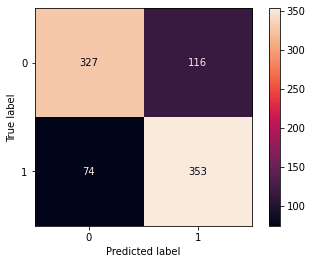

In [259]:
# Confusion matrix
plot_confusion_matrix(rfc1, x_validation, y_validation, cmap='rocket')

In [260]:
# Predictions on test set
rfc_predictions = rfc1.predict(test)

In [261]:
# Create a data frame
data = {'PassengerId': passenger_id,
        'Transported': rfc_predictions}

rfc_pred_df=pd.DataFrame(data=data)

# Check
rfc_pred_df.head()

,PassengerId,Transported
0,0013_01,1
1,0018_01,0
2,0019_01,1
3,0021_01,1
4,0023_01,0


In [262]:
# Change 1 -> True, 0 -> False
rfc_pred_df.replace(to_replace=0, value='False', inplace=True)
rfc_pred_df.replace(to_replace=1, value='True', inplace=True)

# Check
rfc_pred_df.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [ ]:
# Export to CSV
rfc_pred_df.to_csv('rfc_preds.csv', index=False)

# Condensed Cost Model

In [263]:
# New training set
train2 = pd.read_csv('../input/spaceship-titanic/train.csv')

# Check
train2.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [264]:
# Check dtypes
train2.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [265]:
# Handling missing values
# Columns with missing values
train2_nan_cols = train2.columns[train2.isnull().any()]

# Replace missing values in Age with mean
train2.Age.fillna(train2.Age.mean(), inplace=True)

# Replace missing values in RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck with median
# Replace categorical values with most common values
for col in train2_nan_cols:
    if train2[col].dtype == 'object':
        train2[col].fillna(train2[col].mode().iloc[0], inplace=True)
    elif train2[col].dtype == 'float64':
        if train2[col].name != 'Age':
            train2[col].fillna(train2[col].median(), inplace=True)
        else:
            # Do nothing
            continue

In [266]:
# Check there are no nulls
train2.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

In [267]:
# Drop Name from train and test
train2.drop(['Name'], axis = 1, inplace=True)

In [268]:
# Create a new variable that sums up the cost across RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck
# Hold the value per row
train_total_spend =[]

# Iterate through each column in the list
for i in range(len(train2.RoomService)):
    spend_sum = train2.RoomService[i] + train2.FoodCourt[i] + train2.ShoppingMall[i] + train2.Spa[i] + train2.VRDeck[i]
    train_total_spend.append(spend_sum)

# Check
len(train_total_spend)

8693

In [269]:
# Insert
train2.insert(12,'tot_spend', train_total_spend)

# Log (x+1) transformation
train2['tot_spend'] = logTx(train2.tot_spend)

# Check
train2.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,tot_spend,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0.000000,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,6.602588,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,9.248021,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,8.551981,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,6.995766,True


In [270]:
# Get companion count for PassengerId in train data set
train2_companion_count = passengerIdSplitter(train2.PassengerId)

In [271]:
# Add
train2.insert(1, 'companion_count', train2_companion_count)

# Check
train2.head()

,PassengerId,companion_count,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,tot_spend,Transported
0,0001_01,0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0.000000,False
1,0002_01,0,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,6.602588,True
2,0003_01,1,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,9.248021,False
3,0003_02,1,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,8.551981,False
4,0004_01,0,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,6.995766,True


In [272]:
# Get deck, level, and side for train dataframe
train2_deck, train2_level, train2_side = cabinSplitter(train2.Cabin)

In [273]:
# Add to the training data set
train2.insert(4, 'deck', train2_deck)
train2.insert(5, 'level', train2_level)
train2.insert(6, 'side', train2_side)

# Check
train2.head()

,PassengerId,companion_count,HomePlanet,CryoSleep,deck,level,side,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,tot_spend,Transported
0,0001_01,0,Europa,False,B,0,P,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0.000000,False
1,0002_01,0,Earth,False,F,0,S,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,6.602588,True
2,0003_01,1,Europa,False,A,0,S,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,9.248021,False
3,0003_02,1,Europa,False,A,0,S,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,8.551981,False
4,0004_01,0,Earth,False,F,1,S,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,6.995766,True


In [274]:
# Get the categories
train2_level_cat = levelCategorizer(train2.level)

In [275]:
# Insert level_range
train2.insert(5, 'level_range', train2_level_cat)

In [276]:
# Drop PassengerId, Cabin, level, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
train2.drop(['PassengerId', 'Cabin','level', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], axis=1, inplace=True)

# Check
train2.head()

,companion_count,HomePlanet,CryoSleep,deck,level_range,side,Destination,Age,VIP,tot_spend,Transported
0,0,Europa,False,B,<=400,P,TRAPPIST-1e,39.0,False,0.000000,False
1,0,Earth,False,F,<=400,S,TRAPPIST-1e,24.0,False,6.602588,True
2,1,Europa,False,A,<=400,S,TRAPPIST-1e,58.0,True,9.248021,False
3,1,Europa,False,A,<=400,S,TRAPPIST-1e,33.0,False,8.551981,False
4,0,Earth,False,F,<=400,S,TRAPPIST-1e,16.0,False,6.995766,True


In [277]:
# Initialize OrdinalEncoder instance
ord2 = OrdinalEncoder(dtype = 'int64')

In [278]:
# Encoding variables
train2.HomePlanet = ord2.fit_transform(train2.HomePlanet.to_numpy().reshape(-1,1))
train2.CryoSleep = ord2.fit_transform(train2.CryoSleep.to_numpy().reshape(-1,1))
train2.deck = ord2.fit_transform(train2.deck.to_numpy().reshape(-1,1))
train2.level_range = ord2.fit_transform(train2.level_range.to_numpy().reshape(-1,1))
train2.side = ord2.fit_transform(train2.side.to_numpy().reshape(-1,1))
train2.Destination = ord2.fit_transform(train2.Destination.to_numpy().reshape(-1,1))
train2.VIP = ord2.fit_transform(train2.VIP.to_numpy().reshape(-1,1))

# Check
train2.head()

,companion_count,HomePlanet,CryoSleep,deck,level_range,side,Destination,Age,VIP,tot_spend,Transported
0,0,1,0,1,4,0,2,39.0,0,0.000000,False
1,0,0,0,5,4,1,2,24.0,0,6.602588,True
2,1,1,0,0,4,1,2,58.0,1,9.248021,False
3,1,1,0,0,4,1,2,33.0,0,8.551981,False
4,0,0,0,5,4,1,2,16.0,0,6.995766,True


In [279]:
# LabelEncoder
enc2 = LabelEncoder()

# Fit transform
train2['Transported'] = enc2.fit_transform(train2.Transported)

# Check
train2.head()

,companion_count,HomePlanet,CryoSleep,deck,level_range,side,Destination,Age,VIP,tot_spend,Transported
0,0,1,0,1,4,0,2,39.0,0,0.000000,0
1,0,0,0,5,4,1,2,24.0,0,6.602588,1
2,1,1,0,0,4,1,2,58.0,1,9.248021,0
3,1,1,0,0,4,1,2,33.0,0,8.551981,0
4,0,0,0,5,4,1,2,16.0,0,6.995766,1


## Visualizations

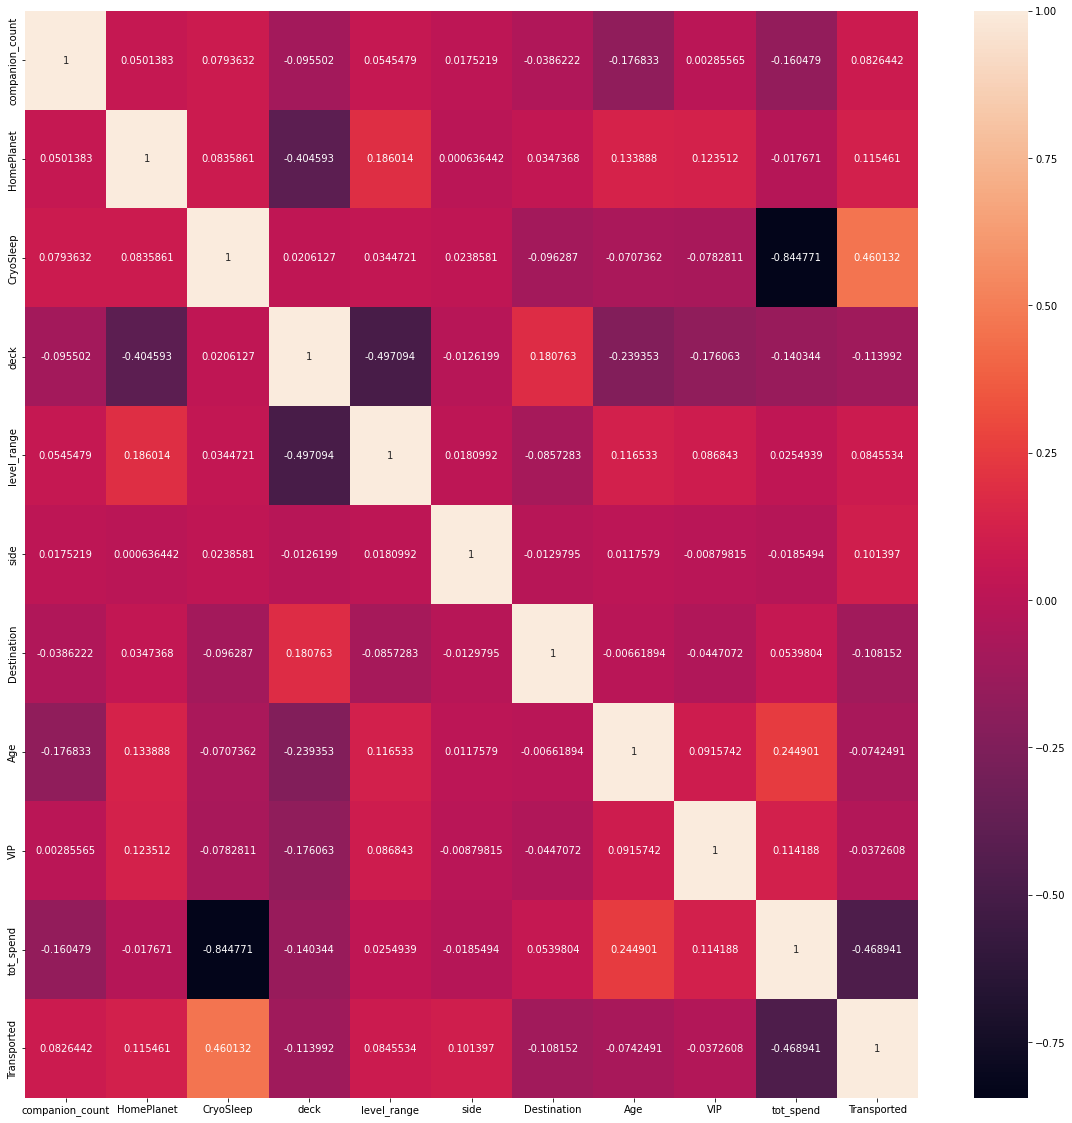

In [280]:
# Heatmap
plt.figure(figsize=(20,20))
sns.heatmap(train2.corr(), annot=True, fmt='g')
plt.show()

There are several variables that have low predictive value regarding the target variable, Transported:
- companion_count, 0.08
- level_range, 0.08
- Age, -0.07
- VIP, -0.04

tot_spend also appears to exhibit high multicollinearity with CryoSleep, which is a one-hot encoded predictor variable that would be expected to have a relationship with tot_spend:
- tot_spend would be higher for those not in CryoSleep as they might need to spend money on food and entertainment.

VIF values will be checked to determine if the multicollinearity is excessive to the point where it would impact the model.
$$VIF = \frac{1}{1-R^{2}}$$

In [281]:
# Check VIF
calcVIF(train2)

,variables,VIF
0,companion_count,1.435051
1,HomePlanet,1.970613
2,CryoSleep,4.886648
3,deck,5.792129
4,level_range,4.964335
5,side,2.068700
6,Destination,4.504466
7,Age,5.771014
8,VIP,1.070191
9,tot_spend,7.173900


Following the rule that a VIF >= 10 is potentially troublesome for a model, it would appear that all of the independent variables except those with very low $R^{2}$ values in the model are safe to retain. However, to start, all variables will be retained regardless of their low predictive value.

In [282]:
# Remove companion_count, level_range, Age, VIP
train2.drop(['Transported'], axis=1, inplace=True)

# Check
train2.head()

,companion_count,HomePlanet,CryoSleep,deck,level_range,side,Destination,Age,VIP,tot_spend
0,0,1,0,1,4,0,2,39.0,0,0.000000
1,0,0,0,5,4,1,2,24.0,0,6.602588
2,1,1,0,0,4,1,2,58.0,1,9.248021
3,1,1,0,0,4,1,2,33.0,0,8.551981
4,0,0,0,5,4,1,2,16.0,0,6.995766


In [283]:
# Split data
x_train2, x_validation2, y_train2, y_validation2 = train_test_split(train2, y, test_size=0.1, random_state=42)

In [284]:
# Evaluation sets for each iteration
eval_sets2 = [(x_train2, y_train2), (x_validation2, y_validation2)]

In [285]:
# New model
# Initialize a new XGBClassifier instance
xgbc2 = XGBClassifier(objective='binary:logistic',
                      nthread=4,
                      seed=42,
                      eval_metric = ['error','logloss']) 

In [288]:
# Parameter list - start with the most important parameters
new_params={'max_depth': [3, 4, 5, 6],
            'n_estimators': [100, 150, 300],
            'eta': [0.05, 0.1, 0.03]}

In [289]:
# New grid search object
gc2 = GridSearchCV(xgbc2, param_grid=new_params, n_jobs=-1, cv=10)

In [290]:
# Fit the grid search object
gc2.fit(x_train2, y_train2)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric=['error', 'logloss'],
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                             

In [291]:
# To a dataframe
gc2_results_pd = pd.DataFrame(gc2.cv_results_)

# View
gc2_results_pd

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,38.706390,3.968731,0.061370,0.007620,0.05,3,100,"{'eta': 0.05, 'max_depth': 3, 'n_estimators': ...",0.747126,0.720307,...,0.734015,0.739130,0.739130,0.754476,0.751918,0.760870,0.764706,0.745497,0.012578,34
1,58.196786,3.620170,0.061370,0.006342,0.05,3,150,"{'eta': 0.05, 'max_depth': 3, 'n_estimators': ...",0.758621,0.729246,...,0.753197,0.754476,0.741688,0.759591,0.767263,0.751918,0.776215,0.754317,0.012247,29
2,113.644424,5.364608,0.060631,0.015294,0.05,3,300,"{'eta': 0.05, 'max_depth': 3, 'n_estimators': ...",0.762452,0.729246,...,0.755754,0.755754,0.744246,0.764706,0.765985,0.748082,0.780051,0.756745,0.013166,18
3,54.702786,6.226267,0.063694,0.012391,0.05,4,100,"{'eta': 0.05, 'max_depth': 4, 'n_estimators': ...",0.763729,0.733078,...,0.758312,0.749361,0.742967,0.764706,0.762148,0.757033,0.778772,0.756617,0.011975,19
4,79.688946,7.145658,0.062549,0.008511,0.05,4,150,"{'eta': 0.05, 'max_depth': 4, 'n_estimators': ...",0.771392,0.739464,...,0.760870,0.753197,0.737852,0.768542,0.769821,0.757033,0.776215,0.759684,0.012391,8
5,157.868691,4.043594,0.074700,0.006573,0.05,4,300,"{'eta': 0.05, 'max_depth': 4, 'n_estimators': ...",0.771392,0.735632,...,0.762148,0.755754,0.751918,0.763427,0.768542,0.757033,0.771100,0.760962,0.010861,3
6,74.130020,5.131533,0.062761,0.007668,0.05,5,100,"{'eta': 0.05, 'max_depth': 5, 'n_estimators': ...",0.763729,0.735632,...,0.763427,0.755754,0.748082,0.765985,0.769821,0.749361,0.785166,0.760452,0.013090,4
7,102.586303,8.494230,0.075989,0.010569,0.05,5,150,"{'eta': 0.05, 'max_depth': 5, 'n_estimators': ...",0.763729,0.730524,...,0.760870,0.751918,0.745524,0.764706,0.763427,0.750639,0.783887,0.758151,0.013623,14
8,199.935620,12.006247,0.056936,0.009686,0.05,5,300,"{'eta': 0.05, 'max_depth': 5, 'n_estimators': ...",0.772669,0.731801,...,0.754476,0.758312,0.750639,0.771100,0.758312,0.750639,0.773657,0.759300,0.012656,10
9,93.118196,7.265484,0.069049,0.018185,0.05,6,100,"{'eta': 0.05, 'max_depth': 6, 'n_estimators': ...",0.765006,0.740741,...,0.757033,0.751918,0.740409,0.760870,0.763427,0.749361,0.773657,0.755338,0.010152,24


In [292]:
# View the best parameters
gc2.best_params_

{'eta': 0.03, 'max_depth': 4, 'n_estimators': 300}

## New Model with Best Parameters

In [311]:
model = XGBClassifier(objective='binary:logistic',
                      eta=0.03,
                      max_depth=4,
                      #max_leaves=30,
                      n_estimators=300,
                      subsample=0.9,
                      gamma = 1.5,
                      nthread=4,
                      seed=42,
                      eval_metric = ['error','logloss'])

In [312]:
# Fit
model.fit(x_train2, y_train2, eval_set=eval_sets2)

[0]	validation_0-error:0.25732	validation_0-logloss:0.68412	validation_1-error:0.27126	validation_1-logloss:0.68462
[1]	validation_0-error:0.25732	validation_0-logloss:0.67554	validation_1-error:0.27126	validation_1-logloss:0.67648
[2]	validation_0-error:0.25821	validation_0-logloss:0.66753	validation_1-error:0.27011	validation_1-logloss:0.66899
[3]	validation_0-error:0.25745	validation_0-logloss:0.66004	validation_1-error:0.27126	validation_1-logloss:0.66181
[4]	validation_0-error:0.25821	validation_0-logloss:0.65282	validation_1-error:0.27011	validation_1-logloss:0.65480
[5]	validation_0-error:0.25821	validation_0-logloss:0.64605	validation_1-error:0.27011	validation_1-logloss:0.64833
[6]	validation_0-error:0.25630	validation_0-logloss:0.63958	validation_1-error:0.27011	validation_1-logloss:0.64234
[7]	validation_0-error:0.25310	validation_0-logloss:0.63359	validation_1-error:0.27126	validation_1-logloss:0.63674
[8]	validation_0-error:0.25438	validation_0-logloss:0.62783	validation_1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.03,
              eval_metric=['error', 'logloss'], gamma=1.5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.0299999993,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=4,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=4, nthread=4,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [313]:
# Accuracy score
model_val_acc_score = accuracy_score(y_validation2, model.predict(x_validation2))
model_train_acc_score = accuracy_score(y_train2, model.predict(x_train2))

# View
print(f"Validation set accuracy score: {model_val_acc_score}.")
print(f"Training set accuracy score: {model_train_acc_score}.")

Validation set accuracy score: 0.7563218390804598.
Training set accuracy score: 0.7770676211172185.


In [314]:
# Performance metrics
model_perf_results = model.evals_result()

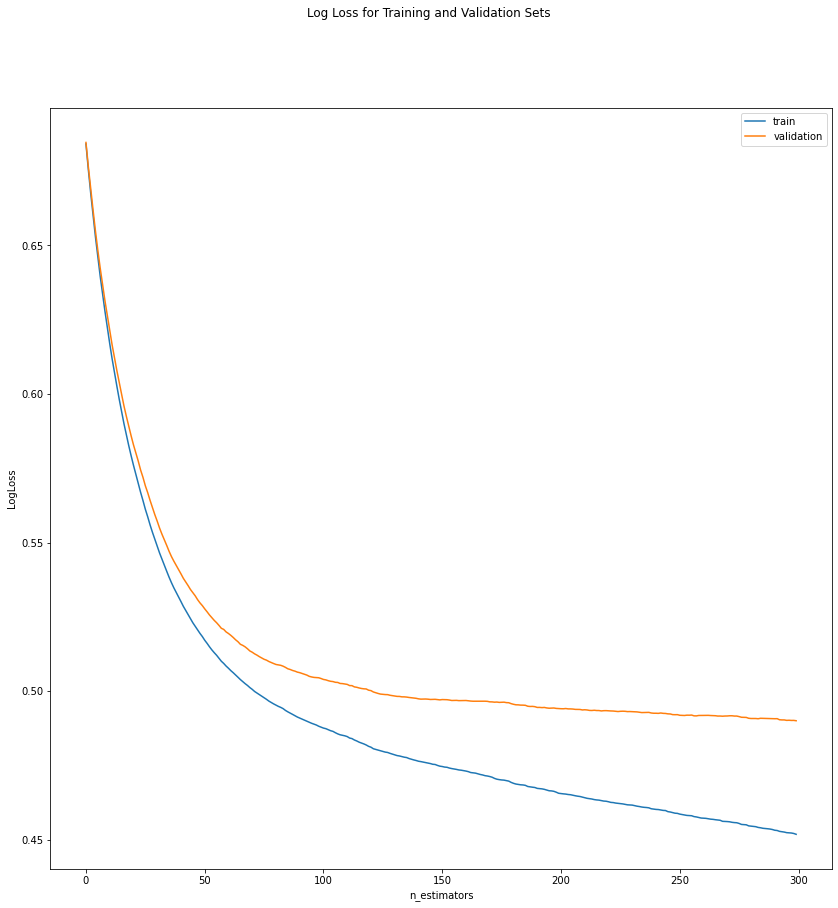

In [315]:
# Plot learning curves
plt.figure(figsize=(14,14))
plt.plot(model_perf_results['validation_0']['logloss'], label='train')
plt.plot(model_perf_results['validation_1']['logloss'], label='validation')

# Show where performance flattens out
#plt.axvline(x = 350, color='black')

# Labels
plt.suptitle('Log Loss for Training and Validation Sets')
plt.xlabel('n_estimators')
plt.ylabel('LogLoss')
# show the legend
plt.legend()
# show the plot
plt.show()

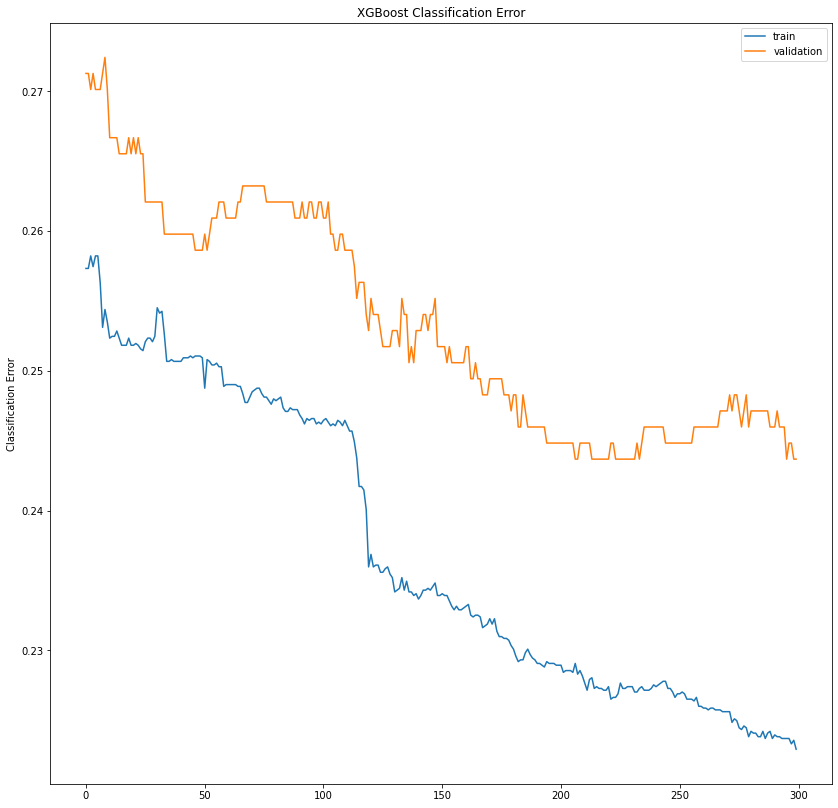

In [316]:
# plot classification error
plt.figure(figsize=(14,14))
plt.plot(model_perf_results['validation_0']['error'], label='train')
plt.plot(model_perf_results['validation_1']['error'], label='validation')
plt.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()